# TP1 - 22.45 Redes Neuronales - Regresión Logística y Lineal

## Regresión Logística

### Import required libraries and dataset

In [1]:
from keras.datasets import fashion_mnist
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
import datetime
from os.path import exists
tf.config.set_visible_devices([], 'GPU')

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import utils
import tensorflow.keras.optimizers as optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers.experimental import preprocessing


from sklearn.metrics import roc_curve, auc
import tensorflow_addons as tfa
from tensorboard.plugins.hparams import api as hp
import keras_tuner

# Load the TensorBoard notebook extension
%load_ext tensorboard

2023-05-22 10:05:01.934335: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-22 10:05:02.363356: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-05-22 10:05:03.183860: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/tobid/itba/neural-networks/tp1/env/lib
2023-05-22 10:05:03.183923: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfe

### Download and load Fashion MNIST dataset

In [2]:
(train_X, train_y), (test_X, test_y) = fashion_mnist.load_data()

### Normalize the dataset

In [3]:
data_max = np.max(train_X)
train_X = train_X.astype('float32') / data_max
test_X = test_X.astype('float32') / data_max
np.max(train_X)

1.0

### Exploratory Data Analysis

#### Example: Show the first object of the train dataset

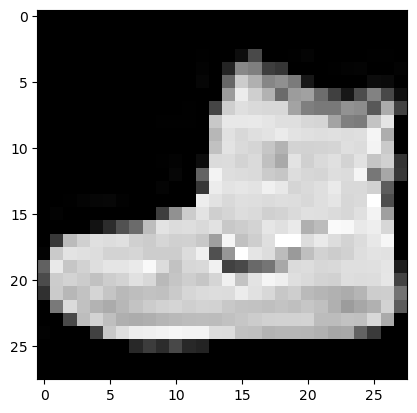

In [4]:
plt.imshow(train_X[0,...], cmap="gray")

#### Show a few instances of each class

In [ ]:
fig = plt.figure(figsize=(40, 40))  # width, height in inches

# idx works on np.array and not lists.
idx = np.argsort(train_y)

train_X_sorted = np.array(train_X)[idx]
train_y_sorted = np.array(train_y)[idx]

count = 0

for i in range(100):
    count = int(np.floor(i / 10))
    sub = fig.add_subplot(10, 10, i + 1, xticks=[], yticks=[])
    sub.imshow(train_X_sorted[i + count * 6000,:,:], interpolation='nearest', cmap='gray')
    sub.set_title('Category: ' + str(train_y_sorted[i + count * 6000]))

#### Look at the data distribution

##### Training data

In [ ]:
unique, counts = np.unique(train_y, return_counts=True)
print(dict(zip(unique, counts)))

counts = np.bincount(train_y)
print(counts)

fig, ax = plt.subplots(figsize=(10,5))
ax.bar(range(10), counts, width=0.8, align='center')
ax.set(xticks=range(10), xlim=[-1, 10], title='Training data distribution')

plt.show()

##### Testing data

In [ ]:
unique, counts = np.unique(test_y, return_counts=True)
print(dict(zip(unique, counts)))

counts = np.bincount(test_y)
print(counts)

fig, ax = plt.subplots(figsize=(10,5))
ax.bar(range(10), counts, width=0.8, align='center')
ax.set(xticks=range(10), xlim=[-1, 10], title='Testing data distribution')

plt.show()

### Convert the dataset from a vector form to a categorical distribution

In [5]:
num_classes = np.max(train_y) + 1
train_y_cat = utils.to_categorical(train_y, num_classes)
test_y_cat = utils.to_categorical(test_y, num_classes)

### Configuring the model

In [6]:
# Callback to stop training if, after 5 epochs, the accuracy is not improving
early_stop_callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5)

In [7]:
# Logs and metrics from TensorBoard
log_dir = "testing/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)

In [8]:
# Callback to save the weights of the best model
checkpoint_filepath = log_dir + '/checkpoint'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

#### Model builder function (with Hyperparameter Tuning)

##### Softmax

In [9]:
def build_model_softmax(hp):
    model = keras.Sequential()
    model.add(layers.Flatten(input_shape=(28, 28)))

    if hp.Boolean("dropout"):
        model.add(layers.Dropout(hp.Float("dropout_rate", 0.1, 0.5, step=0.2, parent_name="dropout", parent_values=[True])))

    if hp.Boolean("batch_normalization"):
        model.add(layers.BatchNormalization())

    model.add(layers.Dense(num_classes, activation='softmax'))
        
    learning_rate = hp.Float("lr", min_value=1e-4, max_value=1e-2, sampling="log", step=10)

    optimizer_list = hp.Choice("optimizer", ["adam", "nadam", "sgd", "rmsprop"])
    if(optimizer_list == "adam" or optimizer_list == "nadam"):
        beta_1 = hp.Float("beta_1", min_value=0.87, max_value=0.99, step=0.04, parent_name="optimizer", parent_values=["adam", "nadam"])
        beta_2 = hp.Float("beta_2", min_value=0.939, max_value=0.999, step=0.03, parent_name="optimizer", parent_values=["adam", "nadam"])
        optimizer = optimizers.Adam(learning_rate=learning_rate, beta_1=beta_1, beta_2=beta_2)
    elif(optimizer_list == "sgd"):
        momentum_1 = hp.Float("momentum_1", min_value=0.90, max_value=0.99, step=0.03, parent_name="optimizer", parent_values=["sgd"])
        optimizer = optimizers.SGD(learning_rate=learning_rate, momentum=momentum_1)
    elif(optimizer_list == "rmsprop"):
        momentum_2 = hp.Float("momentum_2", min_value=0.90, max_value=0.99, step=0.03, parent_name="optimizer", parent_values=["rmsprop"])
        rho = hp.Float("rho", min_value=0.9, max_value=0.99, step=0.03, parent_name="optimizer", parent_values=["rmsprop"])
        optimizer = optimizers.RMSprop(learning_rate=learning_rate, rho=rho, momentum=momentum_2)

    model.compile(
        optimizer=optimizer,
        loss="categorical_crossentropy",
        metrics=["accuracy", tfa.metrics.F1Score(average='macro',num_classes=num_classes),tfa.metrics.F1Score(average='micro',num_classes=num_classes, name="f1_score_micro"), tf.keras.metrics.Precision(name="precision"), tf.keras.metrics.Recall(name="recall")],
    )
    return model

##### MLP

In [23]:
def build_model_mlp(hp):
    model = keras.Sequential()
    model.add(layers.Flatten(input_shape=(28, 28)))

    if hp.Boolean("dropout"):
        model.add(layers.Dropout(hp.Float("dropout_rate", 0.1, 0.5, step=0.2, parent_name="dropout", parent_values=[True])))

    if hp.Boolean("batch_normalization"):
        model.add(layers.BatchNormalization())
    
    for i in range(hp.Int("num_layers", 1, 3)):
      model.add(
        layers.Dense(
          units=hp.Int(f"units_{i}", min_value=32, max_value=512, sampling="log", step=2),
          activation=hp.Choice("activation", ["relu", "tanh", "sigmoid", "elu", "selu", "softplus", "softsign", "exponential"]),
          )
      )

    model.add(layers.Dense(num_classes, activation='softmax'))
        
    learning_rate = hp.Float("lr", min_value=1e-4, max_value=1e-2, sampling="log", step=10)

    optimizer_list = hp.Choice("optimizer", ["adam", "nadam", "sgd", "rmsprop"])
    if(optimizer_list == "adam" or optimizer_list == "nadam"):
        beta_1 = hp.Float("beta_1", min_value=0.87, max_value=0.99, step=0.04, parent_name="optimizer", parent_values=["adam", "nadam"])
        beta_2 = hp.Float("beta_2", min_value=0.939, max_value=0.999, step=0.03, parent_name="optimizer", parent_values=["adam", "nadam"])
        optimizer = optimizers.Adam(learning_rate=learning_rate, beta_1=beta_1, beta_2=beta_2)
    elif(optimizer_list == "sgd"):
        momentum_1 = hp.Float("momentum_1", min_value=0.90, max_value=0.99, step=0.03, parent_name="optimizer", parent_values=["sgd"])
        optimizer = optimizers.SGD(learning_rate=learning_rate, momentum=momentum_1)
    elif(optimizer_list == "rmsprop"):
        momentum_2 = hp.Float("momentum_2", min_value=0.90, max_value=0.99, step=0.03, parent_name="optimizer", parent_values=["rmsprop"])
        rho = hp.Float("rho", min_value=0.9, max_value=0.99, step=0.03, parent_name="optimizer", parent_values=["rmsprop"])
        optimizer = optimizers.RMSprop(learning_rate=learning_rate, rho=rho, momentum=momentum_2)

    model.compile(
        optimizer=optimizer,
        loss="categorical_crossentropy",
        metrics=["accuracy", tfa.metrics.F1Score(average='macro',num_classes=num_classes),tfa.metrics.F1Score(average='micro',num_classes=num_classes, name="f1_score_micro"), tf.keras.metrics.Precision(name="precision"), tf.keras.metrics.Recall(name="recall")],
    )
    return model

##### Testing

Resultados en la carpeta testing/softmax

In [10]:
tuner_softmax = keras_tuner.Hyperband(
    hypermodel=build_model_softmax,
    objective="val_accuracy",
    max_epochs=50,
    overwrite=True,
    directory=log_dir + '/hparams',
    project_name="nn-tp1",
)

tuner_softmax.search_space_summary()

Search space summary
Default search space size: 6
dropout (Boolean)
{'default': False, 'conditions': []}
batch_normalization (Boolean)
{'default': False, 'conditions': []}
lr (Float)
{'default': 0.0001, 'conditions': [], 'min_value': 0.0001, 'max_value': 0.01, 'step': 10, 'sampling': 'log'}
optimizer (Choice)
{'default': 'adam', 'conditions': [], 'values': ['adam', 'nadam', 'sgd', 'rmsprop'], 'ordered': False}
beta_1 (Float)
{'default': 0.87, 'conditions': [{'class_name': 'Parent', 'config': {'name': 'optimizer', 'values': ['adam', 'nadam']}}], 'min_value': 0.87, 'max_value': 0.99, 'step': 0.04, 'sampling': 'linear'}
beta_2 (Float)
{'default': 0.939, 'conditions': [{'class_name': 'Parent', 'config': {'name': 'optimizer', 'values': ['adam', 'nadam']}}], 'min_value': 0.939, 'max_value': 0.999, 'step': 0.03, 'sampling': 'linear'}


2023-05-22 10:05:57.661025: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [11]:
tuner_softmax.search(train_X, train_y_cat, validation_data=(test_X, test_y_cat), batch_size = 64, callbacks=[early_stop_callback, tensorboard_callback])
tuner_softmax.results_summary()

Trial 90 Complete [00h 00m 12s]
val_accuracy: 0.8269000053405762

Best val_accuracy So Far: 0.8475000262260437
Total elapsed time: 00h 11m 51s
INFO:tensorflow:Oracle triggered exit
Results summary
Results in testing/20230522-100521/hparams/nn-tp1
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 0046 summary
Hyperparameters:
dropout: False
batch_normalization: False
lr: 0.001
optimizer: adam
beta_1: 0.95
beta_2: 0.939
tuner/epochs: 17
tuner/initial_epoch: 6
tuner/bracket: 3
tuner/round: 2
tuner/trial_id: 0035
Score: 0.8475000262260437

Trial 0050 summary
Hyperparameters:
dropout: False
batch_normalization: False
lr: 0.001
optimizer: adam
beta_1: 0.95
beta_2: 0.939
tuner/epochs: 50
tuner/initial_epoch: 17
tuner/bracket: 3
tuner/round: 3
tuner/trial_id: 0046
Score: 0.847100019454956

Trial 0048 summary
Hyperparameters:
dropout: False
batch_normalization: False
lr: 0.0001
optimizer: rmsprop
momentum_2: 0.93
rho: 0.93
tuner/epochs: 17
tuner/initial_epoch: 6
tune

Observamos que los mejores modelos para SoftmaxReg entonces resultan ser:
- adam: sin dropout ni batch normalization, con learning rate de 0.001, beta 1 de 0.95 y beta 2 de 0.939
- rmsprop: sin dropout ni batch normalization, con learning rate de 0.0001, momentum de 0.93 y rho de 0.93
- sgd: sin dropout pero con batch normalization, con learning rate de 0.001, momentum de 0.93

Por su rápida velocidad de convergencia, que limita la cantidad de tiempo gastado en entrenamiento, eligiremos el modelo Adam para SoftmaxReg.

In [ ]:
tuner_mlp = keras_tuner.Hyperband(
    hypermodel=build_model_mlp,
    objective="val_accuracy",
    max_epochs=50,
    overwrite=True,
    directory=log_dir + '/hparams',
    project_name="nn-tp1",
)

tuner_softmax.search_space_summary()

In [ ]:
tuner_mlp.search(train_X, train_y_cat, validation_data=(test_X, test_y_cat), batch_size = 64, callbacks=[early_stop_callback, tensorboard_callback])
tuner_mlp.results_summary()

Observamos que los mejores modelos para MLP entonces resultan ser:

Por X elegimos Y

##### Preeliminary Optimizer Analysis

Resultados en la carpeta logs/softmax/optimizer-analysis

In [ ]:
METRICS = [
    hp.Metric(
        "epoch_accuracy",
        group="validation",
        display_name="Accuracy (val.)",
    ),
    hp.Metric(
        "epoch_loss",
        group="validation",
        display_name="Loss (val.)",
    ),
    hp.Metric(
        "epoch_f1_score",
        group="validation",
        display_name="F1 Score Macro (val.)",
    ),
    hp.Metric(
        "epoch_f1_score_micro",
        group="validation",
        display_name="F1 Score Micro (val.)",
    ),
    hp.Metric(
        "epoch_recall",
        group="validation",
        display_name="Recall (val.)",
    ),
    hp.Metric(
        "epoch_precision",
        group="validation",
        display_name="Precision (val.)",
    ),
]

HP_OPTIMIZER = hp.HParam('optimizer', hp.Discrete(['adam', 'sgd', 'rmsprop', 'adamw', 'nadam', 'adagrad', 'adadelta', 'ftrl', 'adamax', 'adafactor']))
HP_LEARN_RATE = hp.HParam('learning_rate', hp.Discrete([0.0001, 0.001, 0.01, 0.1]))
HP_MOMENTUM = hp.HParam('momentum', hp.Discrete([ 0.9, 0.95, 0.99]))
HP_NESTEROV = hp.HParam('nesterov', hp.Discrete([True, False]))
HP_RHO = hp.HParam('rho', hp.Discrete([0.92, 0.95, 0.97]))
HP_BETA_1 = hp.HParam('beta_1', hp.Discrete([0.86, 0.9, 0.94]))
HP_BETA_2 = hp.HParam('beta_2', hp.Discrete([0.97, 0.99, 0.999]))
HP_BETA_2_DECAY = hp.HParam('beta_2_decay', hp.Discrete([-0.9, -0.8, -0.7]))
HP_WEIGHT_DECAY = hp.HParam('weight_decay', hp.Discrete([0.0001, 0.001, 0.004, 0.01]))
HP_LEARN_RATE_POWER = hp.HParam('learning_rate_power', hp.Discrete([-0.8, -0.5, -0.0]))

HPARAMS = [HP_OPTIMIZER, HP_LEARN_RATE, HP_MOMENTUM, HP_NESTEROV, HP_RHO, HP_BETA_1, HP_BETA_2, HP_BETA_2_DECAY, HP_WEIGHT_DECAY, HP_LEARN_RATE_POWER]

In [ ]:
def train_test_model(hparams, run_dir):
  softmax_model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(28,28)),
    tf.keras.layers.Dense(num_classes, activation=tf.nn.softmax),
  ])

  if(hparams[HP_OPTIMIZER] == 'sgd'):
    optimizer = optimizers.SGD(learning_rate=hparams[HP_LEARN_RATE], momentum=hparams[HP_MOMENTUM], nesterov=hparams[HP_NESTEROV])
  elif(hparams[HP_OPTIMIZER] == 'adam'):
    optimizer = optimizers.Adam(learning_rate=hparams[HP_LEARN_RATE])
  elif(hparams[HP_OPTIMIZER] == 'rmsprop'):
    optimizer = optimizers.RMSprop(learning_rate=hparams[HP_LEARN_RATE], rho=hparams[HP_RHO], momentum=hparams[HP_MOMENTUM])
  elif(hparams[HP_OPTIMIZER] == 'adadelta'):
    optimizer = optimizers.Adadelta(learning_rate=hparams[HP_LEARN_RATE], rho=hparams[HP_RHO])
  elif(hparams[HP_OPTIMIZER] == 'adagrad'):
    optimizer = optimizers.Adagrad(learning_rate=hparams[HP_LEARN_RATE])
  elif(hparams[HP_OPTIMIZER] == 'adamax'):
    optimizer = optimizers.Adamax(learning_rate=hparams[HP_LEARN_RATE], beta_1=hparams[HP_BETA_1], beta_2=hparams[HP_BETA_2])
  elif(hparams[HP_OPTIMIZER] == 'nadam'):
    optimizer = optimizers.Nadam(learning_rate=hparams[HP_LEARN_RATE], beta_1=hparams[HP_BETA_1], beta_2=hparams[HP_BETA_2])
  elif(hparams[HP_OPTIMIZER] == 'ftrl'):
    optimizer = optimizers.Ftrl(learning_rate=hparams[HP_LEARN_RATE], learning_rate_power=hparams[HP_LEARN_RATE_POWER])

  softmax_model.compile(
      optimizer=optimizer,
      loss='categorical_crossentropy',
      metrics=["accuracy", tfa.metrics.F1Score(average='macro',num_classes=num_classes),tfa.metrics.F1Score(average='micro',num_classes=num_classes, name="f1_score_micro"), tf.keras.metrics.Precision(name="precision"), tf.keras.metrics.Recall(name="recall")]
  )

  callbacks = [
      early_stop_callback,
      tf.keras.callbacks.TensorBoard(run_dir),# log metrics
      hp.KerasCallback(run_dir, hparams),  # log hparams
    ]

  softmax_model.fit(train_X, train_y_cat, validation_data=(test_X, test_y_cat), batch_size = 64, epochs = 5, callbacks=callbacks)

In [ ]:
with tf.summary.create_file_writer(log_dir).as_default():
  hp.hparams_config(
    hparams=HPARAMS,
    metrics=METRICS,
  )

In [ ]:
session_num = 0

for optimizer in HP_OPTIMIZER.domain.values:
  for learning_rate in HP_LEARN_RATE.domain.values:
    if(optimizer == 'adagrad'):
      hparams = {
        HP_OPTIMIZER: optimizer,
        HP_LEARN_RATE: learning_rate,
      }
      run_name = "/run-%d" % session_num
      print('--- Starting trial: %s' % run_name)
      print({h.name: hparams[h] for h in hparams})
      train_test_model(hparams, log_dir + run_name)
      session_num += 1
    elif(optimizer == 'adadelta'):
      for rho in HP_RHO.domain.values:
        hparams = {
          HP_OPTIMIZER: optimizer,
          HP_LEARN_RATE: learning_rate,
          HP_RHO: rho,
        }
        run_name = "/run-%d" % session_num
        print('--- Starting trial: %s' % run_name)
        print({h.name: hparams[h] for h in hparams})
        train_test_model(hparams, log_dir + run_name)
        session_num += 1
    elif(optimizer == 'ftrl'):
      for learning_rate_power in HP_LEARN_RATE_POWER.domain.values:
        hparams = {
          HP_OPTIMIZER: optimizer,
          HP_LEARN_RATE: learning_rate,
          HP_LEARN_RATE_POWER: learning_rate_power,
        }
        run_name = "/run-%d" % session_num
        print('--- Starting trial: %s' % run_name)
        print({h.name: hparams[h] for h in hparams})
        train_test_model(hparams, log_dir + run_name)
        session_num += 1
    elif(optimizer == 'sgd' or optimizer == 'rmsprop'):
      for momentum in HP_MOMENTUM.domain.values:
        if(optimizer == 'sgd'):
          for nesterov in HP_NESTEROV.domain.values:
            hparams = {
              HP_OPTIMIZER: optimizer,
              HP_LEARN_RATE: learning_rate,
              HP_MOMENTUM: momentum,
              HP_NESTEROV: nesterov,
            }
            run_name = "/run-%d" % session_num
            print('--- Starting trial: %s' % run_name)
            print({h.name: hparams[h] for h in hparams})
            train_test_model(hparams, log_dir + run_name)
            session_num += 1
        else:
          for rho in HP_RHO.domain.values:
            hparams = {
              HP_OPTIMIZER: optimizer,
              HP_LEARN_RATE: learning_rate,
              HP_MOMENTUM: momentum,
              HP_RHO: rho,
            }
            run_name = "/run-%d" % session_num
            print('--- Starting trial: %s' % run_name)
            print({h.name: hparams[h] for h in hparams})
            train_test_model(hparams, log_dir + run_name)
            session_num += 1
    elif(optimizer == 'adam' or optimizer == 'adamax' or optimizer == 'nadam'):
      for beta_1 in HP_BETA_1.domain.values:
        for beta_2 in HP_BETA_2.domain.values:
          hparams = {
            HP_OPTIMIZER: optimizer,
            HP_LEARN_RATE: learning_rate,
            HP_BETA_1: beta_1,
            HP_BETA_2: beta_2,
          }
          run_name = "/run-%d" % session_num
          print('--- Starting trial: %s' % run_name)
          print({h.name: hparams[h] for h in hparams})
          train_test_model(hparams, log_dir + run_name)
          session_num += 1

In [ ]:
%tensorboard --logdir $log_dir

Tenemos entonces un análisis preeliminar de los distintos optimizadores disponibles, y observamos que los que mejor se comportan en terminos de maximizar la accuracy son SGD, RMSprop, Adam y Nadam.
Estos resultados son claramente imperfectos ya que:
- Fueron realizados a solo 5 epochs (lo que le da una ventaja a learning rates altos, y no todos los optimizadores se comportan bien con los mismos).
- No se analizaron otras cuestiones como agregar capas de dropout, batch normalization o cambiar la función de costo, que podrían mejorar la performance de algunos optimizadores en específico.
Sin embargo, sirve como análisis preeliminar para observar cuales optimizadores se comportan bien en general para este problema y realizar un análisis más en profundidad de los mismos, para no requerir tanto tiempo de entrenamiento.

##### First Hyperparameter Tuning with Best Optimizers

Buscamos obtener los mejores hiperparámetros para los optimizadores que mejor se comportaron en el análisis preeliminar, para luego realizar un análisis más en profundidad de los mismos.

In [8]:
METRICS = [
    hp.Metric(
        "epoch_accuracy",
        group="validation",
        display_name="Accuracy (val.)",
    ),
    hp.Metric(
        "epoch_loss",
        group="validation",
        display_name="Loss (val.)",
    ),
    hp.Metric(
        "epoch_f1_score",
        group="validation",
        display_name="F1 Score Macro (val.)",
    ),
    hp.Metric(
        "epoch_f1_score_micro",
        group="validation",
        display_name="F1 Score Micro (val.)",
    ),
    hp.Metric(
        "epoch_recall",
        group="validation",
        display_name="Recall (val.)",
    ),
    hp.Metric(
        "epoch_precision",
        group="validation",
        display_name="Precision (val.)",
    ),
]

# HP_BATCH_RATE = hp.HParam('batch_size', hp.Discrete([32, 64, 128, 256]))
# HP_LOSSES = hp.HParam('loss', hp.Discrete(['categorical_crossentropy', 'mean_squared_error', 'mean_absolute_error', 'mean_absolute_percentage_error', 'mean_squared_logarithmic_error', 'cosine_similarity', 'log_cosh']))
# HP_ACTIVATIONS = hp.HParam('activation', hp.Discrete(['relu', 'sigmoid', 'softmax', 'softplus', 'softsign', 'tanh', 'selu', 'elu', 'exponential']))
# HP_DENSE_LAYERS = hp.HParam('dense_layers', hp.Discrete([1, 2, 3, 4]))
# HP_DENSE_SIZE = hp.HParam('dense_size', hp.Discrete([32, 64, 128, 256, 512]))
# HP_DROPOUT = hp.HParam('dropout', hp.Discrete([0.0, 0.1, 0.2, 0.3, 0.4, 0.5]))
# HP_BATCH_NORMALIZATION = hp.HParam('batch_normalization', hp.Discrete([True, False]))
# HP_WEIGHT_INITIAL = hp.HParam('weight_initialization', hp.Discrete(['glorot_uniform', 'glorot_normal', 'random_normal_std_1', 'random_normal_std_1e-3']))

HP_OPTIMIZER = hp.HParam('optimizer', hp.Discrete(['sgd', 'adam', 'nadam']))
HP_LEARN_RATE = hp.HParam('learning_rate', hp.Discrete([0.0001, 0.001, 0.01]))
HP_MOMENTUM = hp.HParam('momentum', hp.Discrete([ 0.9, 0.95, 0.99]))
HP_NESTEROV = hp.HParam('nesterov', hp.Discrete([True, False]))
HP_BETA_1 = hp.HParam('beta_1', hp.Discrete([0.86, 0.9, 0.94]))
HP_BETA_2 = hp.HParam('beta_2', hp.Discrete([0.97, 0.999]))

HPARAMS = [HP_LEARN_RATE, HP_MOMENTUM, HP_NESTEROV, HP_BETA_1, HP_BETA_2]

In [9]:
# Callback to stop training if, after 5 epochs, the accuracy is not improving
early_stop_callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5)

In [10]:
# Callback to save the weights of the best model
checkpoint_filepath = '/tmp/checkpoint/softmax'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [11]:
# Logs and metrics from TensorBoard
log_dir = "logs/softmax/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)

In [12]:
def train_test_model(hparams, run_dir):
  softmax_model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(28,28)),
    tf.keras.layers.Dense(num_classes, activation=tf.nn.softmax),
  ])
  

  if(hparams[HP_OPTIMIZER] == 'sgd'):
    optimizer = optimizers.SGD(learning_rate=hparams[HP_LEARN_RATE], momentum=hparams[HP_MOMENTUM], nesterov=hparams[HP_NESTEROV])
  elif(hparams[HP_OPTIMIZER] == 'adam'):
    optimizer = optimizers.Adam(learning_rate=hparams[HP_LEARN_RATE], beta_1=hparams[HP_BETA_1], beta_2=hparams[HP_BETA_2])
  elif(hparams[HP_OPTIMIZER] == 'nadam'):
    optimizer = optimizers.Nadam(learning_rate=hparams[HP_LEARN_RATE], beta_1=hparams[HP_BETA_1], beta_2=hparams[HP_BETA_2])
  
  softmax_model.compile(
      optimizer=optimizer,
      loss='categorical_crossentropy',
      metrics=["accuracy", tfa.metrics.F1Score(average='macro',num_classes=num_classes),tfa.metrics.F1Score(average='micro',num_classes=num_classes, name="f1_score_micro"), tf.keras.metrics.Precision(name="precision"), tf.keras.metrics.Recall(name="recall")]
  )

  callbacks = [
      early_stop_callback,
      tf.keras.callbacks.TensorBoard(run_dir),# log metrics
      hp.KerasCallback(run_dir, hparams),  # log hparams
    ]

  softmax_model.fit(train_X, train_y_cat, validation_data=(test_X, test_y_cat), batch_size = 64, epochs = 100, callbacks=callbacks)

In [13]:
with tf.summary.create_file_writer(log_dir).as_default():
  hp.hparams_config(
    hparams=HPARAMS,
    metrics=METRICS,
  )

2023-05-22 07:37:00.432862: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [14]:
session_num = 0

for optimizer in HP_OPTIMIZER.domain.values:
  for learning_rate in HP_LEARN_RATE.domain.values:
    if(optimizer == 'sgd'):
      for momentum in HP_MOMENTUM.domain.values:
        for nesterov in HP_NESTEROV.domain.values:
          hparams = {
            HP_OPTIMIZER: optimizer,
            HP_LEARN_RATE: learning_rate,
            HP_MOMENTUM: momentum,
            HP_NESTEROV: nesterov,
          }
          run_name = "/run-%d" % session_num
          print('--- Starting trial: %s' % run_name)
          print({h.name: hparams[h] for h in hparams})
          train_test_model(hparams, log_dir + run_name)
          session_num += 1
    elif(optimizer == 'adam' or optimizer == 'nadam'):
      for beta_1 in HP_BETA_1.domain.values:
        for beta_2 in HP_BETA_2.domain.values:
          hparams = {
            HP_OPTIMIZER: optimizer,
            HP_LEARN_RATE: learning_rate,
            HP_BETA_1: beta_1,
            HP_BETA_2: beta_2,
          }
          run_name = "/run-%d" % session_num
          print('--- Starting trial: %s' % run_name)
          print({h.name: hparams[h] for h in hparams})
          train_test_model(hparams, log_dir + run_name)
          session_num += 1

--- Starting trial: /run-0
{'optimizer': 'adam', 'learning_rate': 0.0001, 'beta_1': 0.86, 'beta_2': 0.97}
Epoch 1/100
938/938 [==============================] - 2s 2ms/step - loss: 1.1357 - accuracy: 0.6423 - f1_score: 0.6197 - f1_score_micro: 0.6423 - precision: 0.8967 - recall: 0.3269 - val_loss: 0.7920 - val_accuracy: 0.7221 - val_f1_score: 0.7046 - val_f1_score_micro: 0.7221 - val_precision: 0.8637 - val_recall: 0.5511
Epoch 2/100
938/938 [==============================] - 1s 1ms/step - loss: 0.7006 - accuracy: 0.7625 - f1_score: 0.7533 - f1_score_micro: 0.7625 - precision: 0.8705 - recall: 0.6143 - val_loss: 0.6657 - val_accuracy: 0.7658 - val_f1_score: 0.7552 - val_f1_score_micro: 0.7658 - val_precision: 0.8630 - val_recall: 0.6494
Epoch 3/100
938/938 [==============================] - 1s 1ms/step - loss: 0.6155 - accuracy: 0.7936 - f1_score: 0.7880 - f1_score_micro: 0.7936 - precision: 0.8737 - recall: 0.6796 - val_loss: 0.6117 - val_accuracy: 0.7915 - val_f1_score: 0.7874 - val

KeyboardInterrupt: 

##### Final testing with best hyperparameters

In [ ]:
softmax_model =  Sequential()
#model.add(preprocessing.RandomFlip("horizontal", input_shape=(28,28,1)))
# model.add(layers.Dropout(0.1, input_shape=(28,28)))
softmax_model.add(layers.Flatten(input_shape=(28,28)))
softmax_model.add(layers.Dense(num_classes, activation="softmax"))
softmax_model.summary()

#### Softmax model performance

In [ ]:
# Callback to stop training if, after 5 epochs, the accuracy is not improving
early_stop_callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5)

In [ ]:
# Callback to save the weights of the best model
checkpoint_filepath = '/tmp/checkpoint/softmax'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [ ]:
# Logs and metrics from TensorBoard
log_dir_fit = "logs/fit/softmax/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir_fit, histogram_freq=1)

In [ ]:
optimizer = SGD(learning_rate=0.0002, momentum=0.95)
softmax_model.compile(loss = 'categorical_crossentropy', optimizer=optimizers.Adam(learning_rate=0.001, beta_1=0.95, beta_2=0.94),metrics=["accuracy", tfa.metrics.F1Score(average='macro',num_classes=num_classes),tfa.metrics.F1Score(average='micro',num_classes=num_classes, name="f1_score_micro"), tf.keras.metrics.Precision(name="precision"), tf.keras.metrics.Recall(name="recall")])

#### Fit the model to the train data and validate it with the test data

In [ ]:
# We load the previously best weights to save time on training
# if (exists(checkpoint_filepath)):
    # softmax_model.load_weights(checkpoint_filepath)

In [ ]:
softmax_history = softmax_model.fit(train_X, train_y_cat, validation_data=(test_X, test_y_cat), batch_size = 32, epochs=100, callbacks=[tensorboard_callback, early_stop_callback])
# softmax_history = softmax_model.fit(train_X, train_y_cat, validation_data=(test_X, test_y_cat), batch_size = 64, epochs=10, callbacks=[model_checkpoint_callback, tensorboard_callback, early_stop_callback])

#### Plot important metrics

##### TensorBoard session

In [ ]:
%tensorboard --logdir logs/fit

##### Loss

In [ ]:
plt.plot(softmax_history.history["loss"], label="Train")
plt.plot(softmax_history.history["val_loss"], label="Validation")
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss evolution through epochs - Softmax')
plt.show()

##### Accuracy

In [ ]:
plt.plot(softmax_history.history["accuracy"], label="Train")
plt.plot(softmax_history.history["val_accuracy"], label="Validation")
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy evolution through epochs - Softmax')
plt.show()

##### Precision

In [ ]:
plt.plot(softmax_history.history["precision"], label="Train")
plt.plot(softmax_history.history["val_precision"], label="Validation")
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.title('Precision evolution through epochs - Softmax')
plt.show()

##### Recall

In [ ]:
plt.plot(softmax_history.history["recall"], label="Train")
plt.plot(softmax_history.history["val_recall"], label="Validation")
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.title('Recall evolution through epochs - Softmax')
plt.show()

##### F1-Score

###### Macro

In [ ]:
plt.plot(softmax_history.history["f1_score"], label="Train")
plt.plot(softmax_history.history["val_f1_score"], label="Validation")
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('F1 Score (Macro)')
plt.title('F1 Score (Macro) evolution through epochs - Softmax')
plt.show()

###### Micro

In [ ]:
plt.plot(softmax_history.history["f1_score_micro"], label="Train")
plt.plot(softmax_history.history["val_f1_score_micro"], label="Validation")
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('F1 Score (Micro)')
plt.title('F1 Score (Micro) evolution through epochs - Softmax')
plt.show()

En este problema los F1 Score tanto macro como micro son muy similares a causa de que no existe desbalance de clases.

##### ROC and AUC

In [ ]:
# Plot linewidth.
lw = 2

# Get score
y_score = softmax_model.predict(test_X)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(test_y_cat[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(test_y_cat.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(num_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(num_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= num_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(1, figsize=(10,10))
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

#colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
#for i, color in zip(range(num_classes), colors):
#    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
#             label='ROC curve of class {0} (area = {1:0.2f})'
#             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Extension of Receiver Operating Characteristic to multi-class - Softmax')
plt.legend(loc="lower right")
plt.show()


# Zoom in view of the upper left corner.
plt.figure(2, figsize=(20,10))
plt.xlim(0, 0.2)
plt.ylim(0.8, 1)
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

#colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
#for i, color in zip(range(num_classes), colors):
#    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
#             label='ROC curve of class {0} (area = {1:0.2f})'
#             ''.format(i, roc_auc[i]))
    
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Zoomed - Extension of Receiver Operating Characteristic to multi-class - Softmax')
plt.legend(loc="lower right")
plt.show()

Al igual que para el F1 Score, las curvas ROC tanto macro como micro dan muy similares porque no hay desbalance de clases.

### MLP

In [ ]:
mlp_model = Sequential()
mlp_model.add(layers.Flatten(input_shape=(28,28)))
mlp_model.add(layers.Dense(256, activation='relu'))
mlp_model.add(layers.Dense(64, activation='relu'))
mlp_model.add(layers.Dense(num_classes, activation="softmax"))
mlp_model.summary()

#### Compile the model

In [ ]:
mlp_model.compile(loss = 'categorical_crossentropy', optimizer=SGD(learning_rate=0.0002, momentum=0.95),metrics=["accuracy", tfa.metrics.F1Score(average='macro',num_classes=num_classes),tfa.metrics.F1Score(average='micro',num_classes=num_classes, name="f1_score_micro"), tf.keras.metrics.Precision(name="precision"), tf.keras.metrics.Recall(name="recall")])

In [ ]:
# Callback to stop training if, after 2 epochs, the accuracy is not improving
early_stop_callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)

In [ ]:
# Callback to save the weights of the best model
checkpoint_filepath = '/tmp/checkpoint/mlp'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [ ]:
# Logs and metrics from TensorBoard
log_dir_fit = "logs/fit/mlp/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir_fit, histogram_freq=1)

#### Fit the model to the train data and validate it with the test data

In [ ]:
# We load the previously best weights to save time on training
# if (exists(checkpoint_filepath)):
    # mlp_model.load_weights(checkpoint_filepath)

In [ ]:
mlp_history = mlp_model.fit(train_X, train_y_cat, validation_data=(test_X, test_y_cat), batch_size = 64, epochs=10, callbacks=[tensorboard_callback, early_stop_callback])
# softmax_history = softmax_model.fit(train_X, train_y_cat, validation_data=(test_X, test_y_cat), batch_size = 64, epochs=10, callbacks=[model_checkpoint_callback, tensorboard_callback, early_stop_callback])
# mlp_history = mlp_model.fit(train_X, train_y_cat, validation_data=(test_X, test_y_cat), batch_size = 64, epochs=10, callbacks=[model_checkpoint_callback, tensorboard_callback, early_stop_callback])

#### Plot important metrics

##### TensorBoard session

In [ ]:
%tensorboard --logdir logs/fit

##### Loss

In [ ]:
plt.plot(mlp_history.history["loss"], label="Train")
plt.plot(mlp_history.history["val_loss"], label="Validation")
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss evolution through epochs - MLP')
plt.show()

##### Accuracy

In [ ]:
plt.plot(mlp_history.history["accuracy"], label="Train")
plt.plot(mlp_history.history["val_accuracy"], label="Validation")
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy evolution through epochs - MLP')
plt.show()

##### Precision

In [ ]:
plt.plot(mlp_history.history["precision"], label="Train")
plt.plot(mlp_history.history["val_precision"], label="Validation")
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.title('Precision evolution through epochs - MLP')
plt.show()

##### Recall

In [ ]:
plt.plot(mlp_history.history["recall"], label="Train")
plt.plot(mlp_history.history["val_recall"], label="Validation")
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.title('Recall evolution through epochs - MLP')
plt.show()

##### F1 Score

###### Macro

In [ ]:
plt.plot(mlp_history.history["f1_score"], label="Train")
plt.plot(mlp_history.history["val_f1_score"], label="Validation")
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('F1 Score (Macro)')
plt.title('F1 Score (Macro) evolution through epochs - MLP')
plt.show()

###### Micro

In [ ]:
plt.plot(mlp_history.history["f1_score_micro"], label="Train")
plt.plot(mlp_history.history["val_f1_score_micro"], label="Validation")
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('F1 Score (Micro)')
plt.title('F1 Score (Micro) evolution through epochs - MLP')
plt.show()

##### ROC and AUC

In [ ]:
# Plot linewidth.
lw = 2

# Get score
y_score = mlp_model.predict(test_X)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(test_y_cat[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(test_y_cat.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(num_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(num_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= num_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(1, figsize=(10,10))
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

#colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
#for i, color in zip(range(num_classes), colors):
#    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
#             label='ROC curve of class {0} (area = {1:0.2f})'
#             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Extension of Receiver Operating Characteristic to multi-class - MLP')
plt.legend(loc="lower right")
plt.show()


# Zoom in view of the upper left corner.
plt.figure(2, figsize=(20,10))
plt.xlim(0, 0.2)
plt.ylim(0.8, 1)
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

#colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
#for i, color in zip(range(num_classes), colors):
#    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
#             label='ROC curve of class {0} (area = {1:0.2f})'
#             ''.format(i, roc_auc[i]))
    
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Zoomed - Extension of Receiver Operating Characteristic to multi-class - MLP')
plt.legend(loc="lower right")
plt.show()